In [1]:
# Import Necessary Libraries
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose, DecomposeResult
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

In [2]:
national_df = pd.read_csv("Data/national_data.csv")

states_df = pd.read_csv("Data/states_data.csv")

## Load Data
This assumes data has already been downloaded and unzipped. Alternative: Add those steps to the notebook.

Load state data __and__ national data. The national data will be stored as another state: US

In [2]:
# STATE DATA
file_paths = glob.glob('namesbystate/STATE.*.TXT')

list_of_dfs = []

for file_path in file_paths:
    temp_df = pd.read_csv(file_path, names=['state', 'M/F', 'year', 'name','count'])
    list_of_dfs.append(temp_df)

dfraw1 = pd.concat(list_of_dfs, ignore_index=True)
dfraw1.head()

,state,M/F,year,name,count
0,ID,F,1910,Mary,53
1,ID,F,1910,Dorothy,31
2,ID,F,1910,Helen,30
3,ID,F,1910,Margaret,24
4,ID,F,1910,Ruth,24


In [3]:
# NATIONAL DATA (which is 50 states plus DC)
file_paths = glob.glob('names/yob*.txt')

list_of_dfs = []

for file_path in file_paths:
    temp_df = pd.read_csv(file_path, names=['name', 'M/F', 'count'])
    year = int(file_path.split('yob')[1].split('.txt')[0])
    temp_df['year'] = year
    list_of_dfs.append(temp_df)

dfraw2 = pd.concat(list_of_dfs, ignore_index=True)

dfraw2['year'] = dfraw2['year'].astype(int)
dfraw2['state'] = 'US'
dfraw2 = dfraw2[['state', 'M/F', 'year', 'name', 'count']]

dfraw2.head()

ValueError: No objects to concatenate

In [4]:
# concatenate the sytate and national data. In other words, treat "US" as just another state
dfraw = pd.concat([dfraw1, dfraw2], ignore_index=True)
dfraw.head()

,state,M/F,year,name,count
0,ID,F,1910,Mary,53
1,ID,F,1910,Dorothy,31
2,ID,F,1910,Helen,30
3,ID,F,1910,Margaret,24
4,ID,F,1910,Ruth,24


## verify format of names
Verify that the SSA strips away all spaces and punctuation. Verify that the names are: 
* Only letters
* The first letter is always capitalized, the remainig letters are all lower-case.

In [5]:
def check_format(s):
    return s.isalpha() and s[0].isupper() and s[1:].islower()
dfraw['is_valid'] = dfraw['name'].apply(check_format)
print('Below is the list if names that are not valid:')
print('---------------')
print(dfraw[~dfraw["is_valid"]])
dfraw.drop(['is_valid'], axis=1, inplace=True)

Below is the list if names that are not valid:
---------------
Empty DataFrame
Columns: [state, M/F, year, name, count, is_valid]
Index: []


## consolidate name and M/F for easier coding
The SSA lists "Parker M" and "Parker F" separately, so combine those fields into one. Otherwise we'll always have to group by both.

**NOTE:** In general, don't do this. M/F is a variable that may help prediction, etc.

In [6]:
# consolidate the columns
df1 = dfraw.copy()
df1['name'] = df1['name'] + '-' + df1['M/F']
df1.drop(['M/F'], axis=1, inplace=True)
df1.sample(5)

,state,year,name,count
4852743,MA,1995,Maritza-F,5
511621,PA,1927,Peggy-F,182
4370903,MS,1947,Perry-M,35
481654,FL,2013,Aayden-M,11
7730223,US,1978,Isaac-F,12


## note on data structure (and list of dataframes)
We may aggregate data by name, by state, by year, and by various combinations of those fields. To keep things straight, the aggregated data will be stored in separate dataframes, like tables in a relational database. So there will be dataframes named:
* name
* state
* year
* name_state
* state_year
* ...

## normalize counts
Because the total number of births varies over the years, we'll use % of total births (per geographical area) instead of the raw count of names 

In [7]:
# create state_year df with count of births for that state_year (and other aggregated data?)
state_year = df1.groupby(['state', 'year']).sum(numeric_only=True).reset_index()
state_year.sample(5)

,state,year,count
619,CO,1964,37860
5067,US,1975,3019730
717,CT,1949,35898
2750,MO,1948,79802
4979,US,1887,247393


In [8]:
# add the percentage column: count of that name divided by total count for that geographical area
df2 = pd.merge(df1, state_year, on=['state', 'year'], how='left', suffixes=('', '_agg'))
df2['perc'] = 100*df2['count']/df2['count_agg']
df2.drop(['count_agg'], axis=1, inplace=True)
df2.head()

,state,year,name,count,perc
0,ID,1910,Mary-F,53,4.866850
1,ID,1910,Dorothy-F,31,2.846648
2,ID,1910,Helen-F,30,2.754821
3,ID,1910,Margaret-F,24,2.203857
4,ID,1910,Ruth-F,24,2.203857


## how many names are there? How many names have gaps in the years?
By "gap" I mean a name that is listed, then disappears, then re-appears.

(If a count is less than 5 (for a year and state), the SSA does not list the name.)

This might inform how to handle gaps / missing data. For example, if a name had count 6 on 2001, a gap in 2002, and count 6 in 2003, it might be reasonable to assign it a number of, say, 4 in 2002.

In [9]:
# Find gaps in years for each name/state combination
df2.sort_values(by=['state', 'name', 'year'], inplace=True) # not sure this is needed
df2['prev_yr'] = df2.groupby(['state', 'name'])['year'].shift()
df2['year_diff']=df2['year']-df2['prev_yr']

df2.loc[df2['year_diff'] > 1, 'gap_start'] = df2['prev_yr']+1
df2.loc[df2['year_diff'] > 1, 'gap_end'] = df2['year']-1

df2.loc[df2['name']=='Cyril-M'].head(10)

,state,year,name,count,perc,prev_yr,year_diff,gap_start,gap_end
1495918,AL,1957,Cyril-M,5,0.006573,NaN,NaN,NaN,NaN
3702475,AR,1916,Cyril-M,6,0.019938,NaN,NaN,NaN,NaN
3706212,AR,1924,Cyril-M,5,0.012492,1916.0,8.0,1917.0,1923.0
3156687,CA,1913,Cyril-M,10,0.045261,NaN,NaN,NaN,NaN
3157461,CA,1915,Cyril-M,6,0.016743,1913.0,2.0,1914.0,1914.0
3157683,CA,1916,Cyril-M,17,0.045332,1915.0,1.0,NaN,NaN
3158631,CA,1918,Cyril-M,8,0.017900,1916.0,2.0,1917.0,1917.0
3159018,CA,1919,Cyril-M,13,0.028813,1918.0,1.0,NaN,NaN
3160118,CA,1921,Cyril-M,8,0.013563,1919.0,2.0,1920.0,1920.0
3160601,CA,1922,Cyril-M,10,0.016392,1921.0,1.0,NaN,NaN


In [10]:
# Create a dataframe of gaps
name_state_gap = df2[~df2['gap_end'].isnull()]
name_state_gap = name_state_gap[['state', 'name', 'gap_start', 'gap_end']]
name_state_gap['gap_length'] = 1 + name_state_gap['gap_end'] - name_state_gap['gap_start']
name_state_gap.head()

,state,name,gap_start,gap_end,gap_length
2849048,AK,Aaliyah-F,2000.0,2000.0,1.0
2852852,AK,Aaliyah-F,2018.0,2018.0,1.0
2856034,AK,Aaron-M,1957.0,1958.0,2.0
2856978,AK,Aaron-M,1961.0,1964.0,4.0
2849013,AK,Abby-F,1984.0,2000.0,17.0


In [12]:
# create name_state df that contains aggregated data
name_state = df2.groupby(['name', 'state']).agg(
    first_year = ('year', np.min),
    last_year = ('year', np.max),
    max_perc = ('perc', np.max),
    ).reset_index()
name_state['year_range'] = 1+name_state['last_year']-name_state['first_year']
name_state.head()

,name,state,first_year,last_year,max_perc,year_range
0,Aaban-M,NY,2013,2014,0.003098,2
1,Aaban-M,US,2007,2022,0.000432,16
2,Aabha-F,US,2011,2022,0.000243,12
3,Aabid-M,US,2003,2018,0.000171,16
4,Aabidah-F,US,2018,2018,0.000142,1


In [13]:
print('count of unique name state combos: ', len(name_state))

count of unique name state combos:  451418


In [14]:
print('count of name state combos with gaps: ', len(name_state_gap[['name', 'state']].groupby(['name', 'state'])))

count of name state combos with gaps:  315143


MOST NAMES HAVE GAPS

In [15]:
# look at some gaps
df2[~df2['gap_end'].isnull()].sample(20)

,state,year,name,count,perc,prev_yr,year_diff,gap_start,gap_end
6619333,US,2003,Mckalee-F,5,0.000132,1997.0,6.0,1998.0,2002.0
1326291,MO,2018,Jolee-F,5,0.008819,2010.0,8.0,2011.0,2017.0
1111437,NC,1981,Kechia-F,5,0.007044,1973.0,8.0,1974.0,1980.0
5618618,SC,2021,Maison-M,5,0.013212,2019.0,2.0,2020.0,2020.0
3245960,CA,1994,Anson-M,6,0.001178,1992.0,2.0,1993.0,1993.0
2531393,MI,1976,Shayna-F,7,0.006059,1972.0,4.0,1973.0,1975.0
3688434,AR,2004,Natalia-F,6,0.022156,2002.0,2.0,2003.0,2003.0
4415997,NH,1950,Toni-F,8,0.079083,1948.0,2.0,1949.0,1949.0
2538153,MI,1982,Domonique-F,5,0.004081,1974.0,8.0,1975.0,1981.0
2181980,TX,1988,Mahogany-F,6,0.002203,1986.0,2.0,1987.0,1987.0


Most gaps are for infrequently used names

What name/states combos don't have any gaps? Add indicator to name_state?

## add difference and acceleration columns
(acceleration is the second order difference)

It is OK that there are gaps in the data. For example, it will just show-up as a difference of 1% over 2 years

**NOTE**: perc_diff is not the same as percent growth. Example (see mini dataframe below):

In [16]:
zzz =[[2001, 10],
       [2002, 15],
       [2003, 6]
      ]
temp = pd.DataFrame(zzz, columns=['year', 'count'])
temp['state_total'] = 100
temp['perc'] = 100*temp['count']/temp['state_total']
temp['perc_diff'] = temp['perc'].diff()
temp['perc_growth']=100*temp['count'].pct_change()
temp

,year,count,state_total,perc,perc_diff,perc_growth
0,2001,10,100,10.0,NaN,NaN
1,2002,15,100,15.0,5.0,50.0
2,2003,6,100,6.0,-9.0,-60.0


In [17]:
# take a look at the data, for reference
df2 = df2.sort_values(by=['name', 'state', 'year'])
df2['perc_diff'] = df2.groupby(['name', 'state'])['perc'].diff() # .fillna(0)
df2['accel'] = df2.groupby(['name', 'state'])['perc_diff'].diff() # .fillna(0)
df2.loc[df2['name']=='Aaden-M'].head(20)

,state,year,name,count,perc,prev_yr,year_diff,gap_start,gap_end,perc_diff,accel
1524447,AL,2007,Aaden-M,5,0.010775,NaN,NaN,NaN,NaN,NaN,NaN
1524857,AL,2008,Aaden-M,15,0.032563,2007.0,1.0,NaN,NaN,0.021788,NaN
1525521,AL,2009,Aaden-M,28,0.063426,2008.0,1.0,NaN,NaN,0.030863,0.009076
1526628,AL,2010,Aaden-M,8,0.018937,2009.0,1.0,NaN,NaN,-0.044489,-0.075352
1527352,AL,2011,Aaden-M,10,0.024055,2010.0,1.0,NaN,NaN,0.005118,0.049607
1528238,AL,2012,Aaden-M,7,0.017229,2011.0,1.0,NaN,NaN,-0.006825,-0.011943
1529124,AL,2013,Aaden-M,5,0.012191,2012.0,1.0,NaN,NaN,-0.005039,0.001786
1530721,AL,2015,Aaden-M,5,0.011681,2013.0,2.0,2014.0,2014.0,-0.000509,0.004530
1532139,AL,2017,Aaden-M,8,0.019055,2015.0,2.0,2016.0,2016.0,0.007373,0.007883
3740964,AR,2008,Aaden-M,13,0.047414,NaN,NaN,NaN,NaN,NaN,NaN


## look at ~10 sample name/state combos to get a feel for different time series shapes

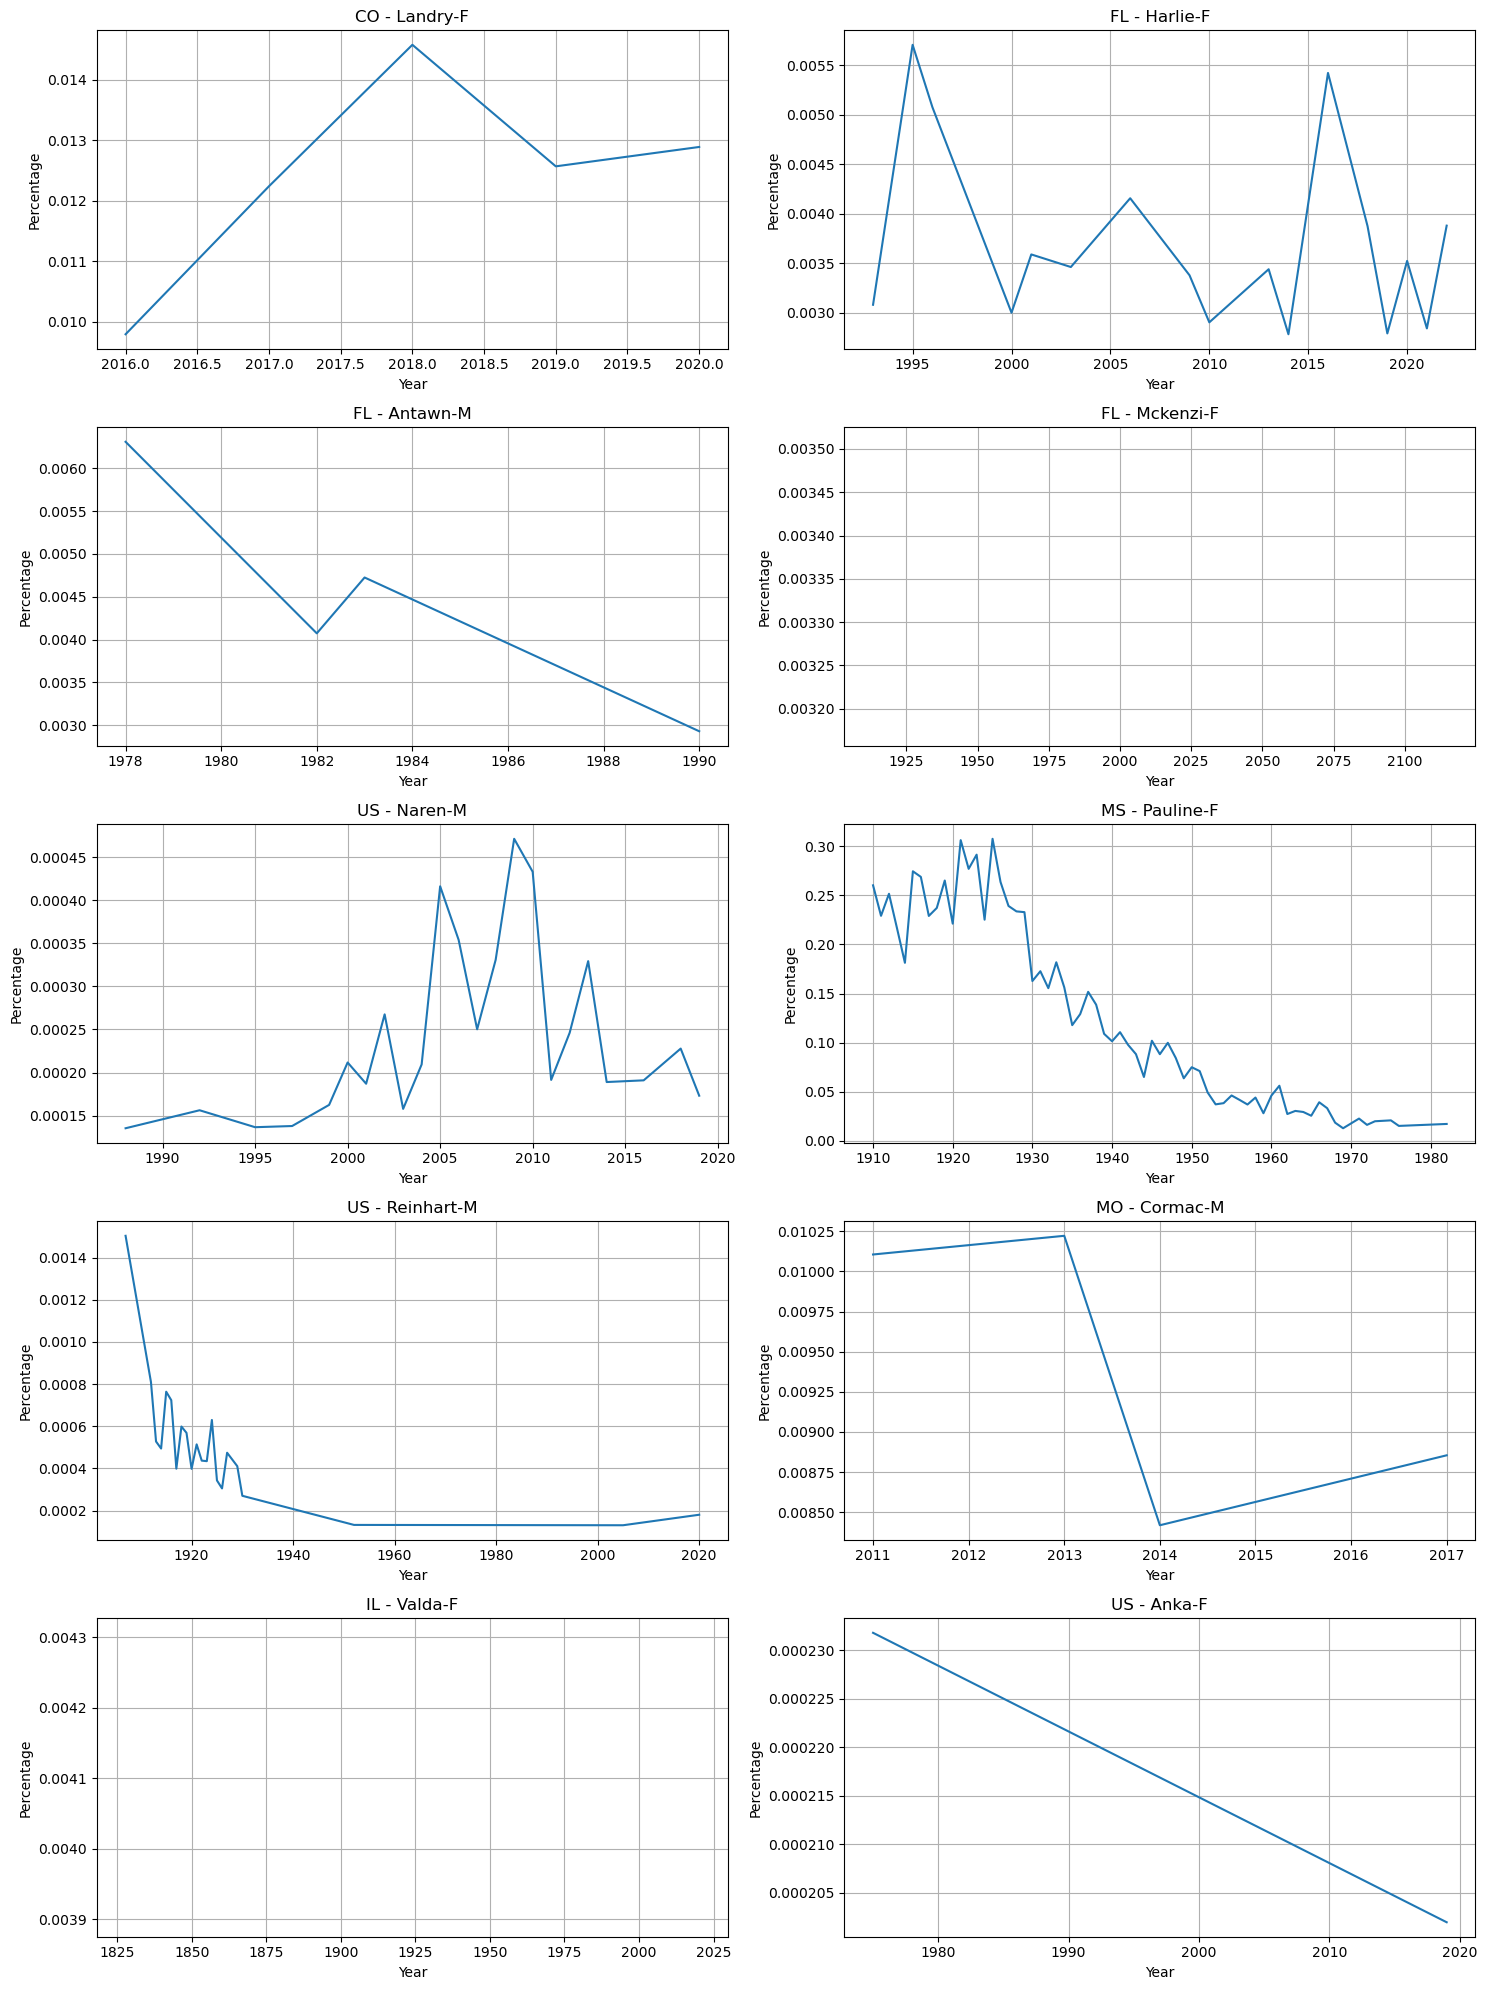

In [18]:
np.random.seed(42)

unique_combinations = df2.drop_duplicates(subset=['state', 'name'])
sampled_combinations = unique_combinations.sample(n=10)

fig, axs = plt.subplots(5, 2, figsize=(15, 20))  # 5x2 subplots
axs = axs.flatten()  # Flatten the array for easy iteration

for i, (index, row) in enumerate(sampled_combinations.iterrows()):
    data_subset = df2[(df2['state'] == row['state']) & (df2['name'] == row['name'])]
    
    axs[i].plot(data_subset['year'], data_subset['perc'])
    axs[i].set_title(f"{row['state']} - {row['name']}")
    axs[i].set_xlabel('Year')
    axs[i].set_ylabel('Percentage')
    axs[i].grid(True)

plt.tight_layout()
plt.show()

## do the same for *common* names
Maybe define "common" as any name that reaches a certain percent?

possible other criteria: 
* names that don't have any gaps
* names that have a big range of years

Look at the distribution of max percents

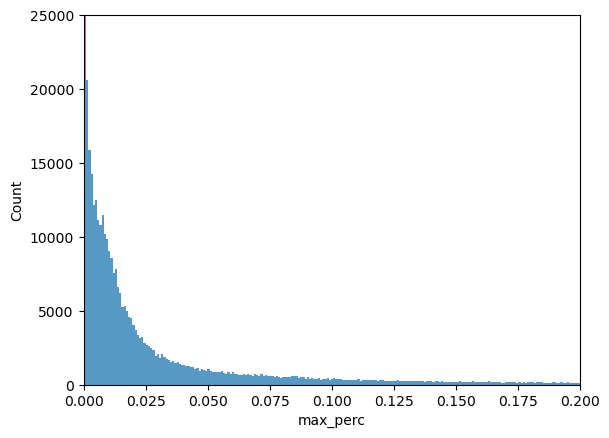

In [19]:
sns.histplot(name_state['max_perc'])
plt.xlim(0, 0.2)
plt.ylim(0, 25000)

plt.show()

In [20]:
# set the threshold for percent for "common" names 
threshold_percent = 0.1

In [21]:
# list of common names
common_names = name_state.loc[name_state['max_perc']>=threshold_percent]
print(len(common_names))
common_names.head()

58775


,name,state,first_year,last_year,max_perc,year_range
404,Aaliyah-F,AK,1999,2022,0.263759,24
405,Aaliyah-F,AL,1994,2022,0.211681,29
406,Aaliyah-F,AR,1994,2022,0.203925,29
407,Aaliyah-F,AZ,1995,2022,0.262081,28
408,Aaliyah-F,CA,1977,2022,0.181139,46


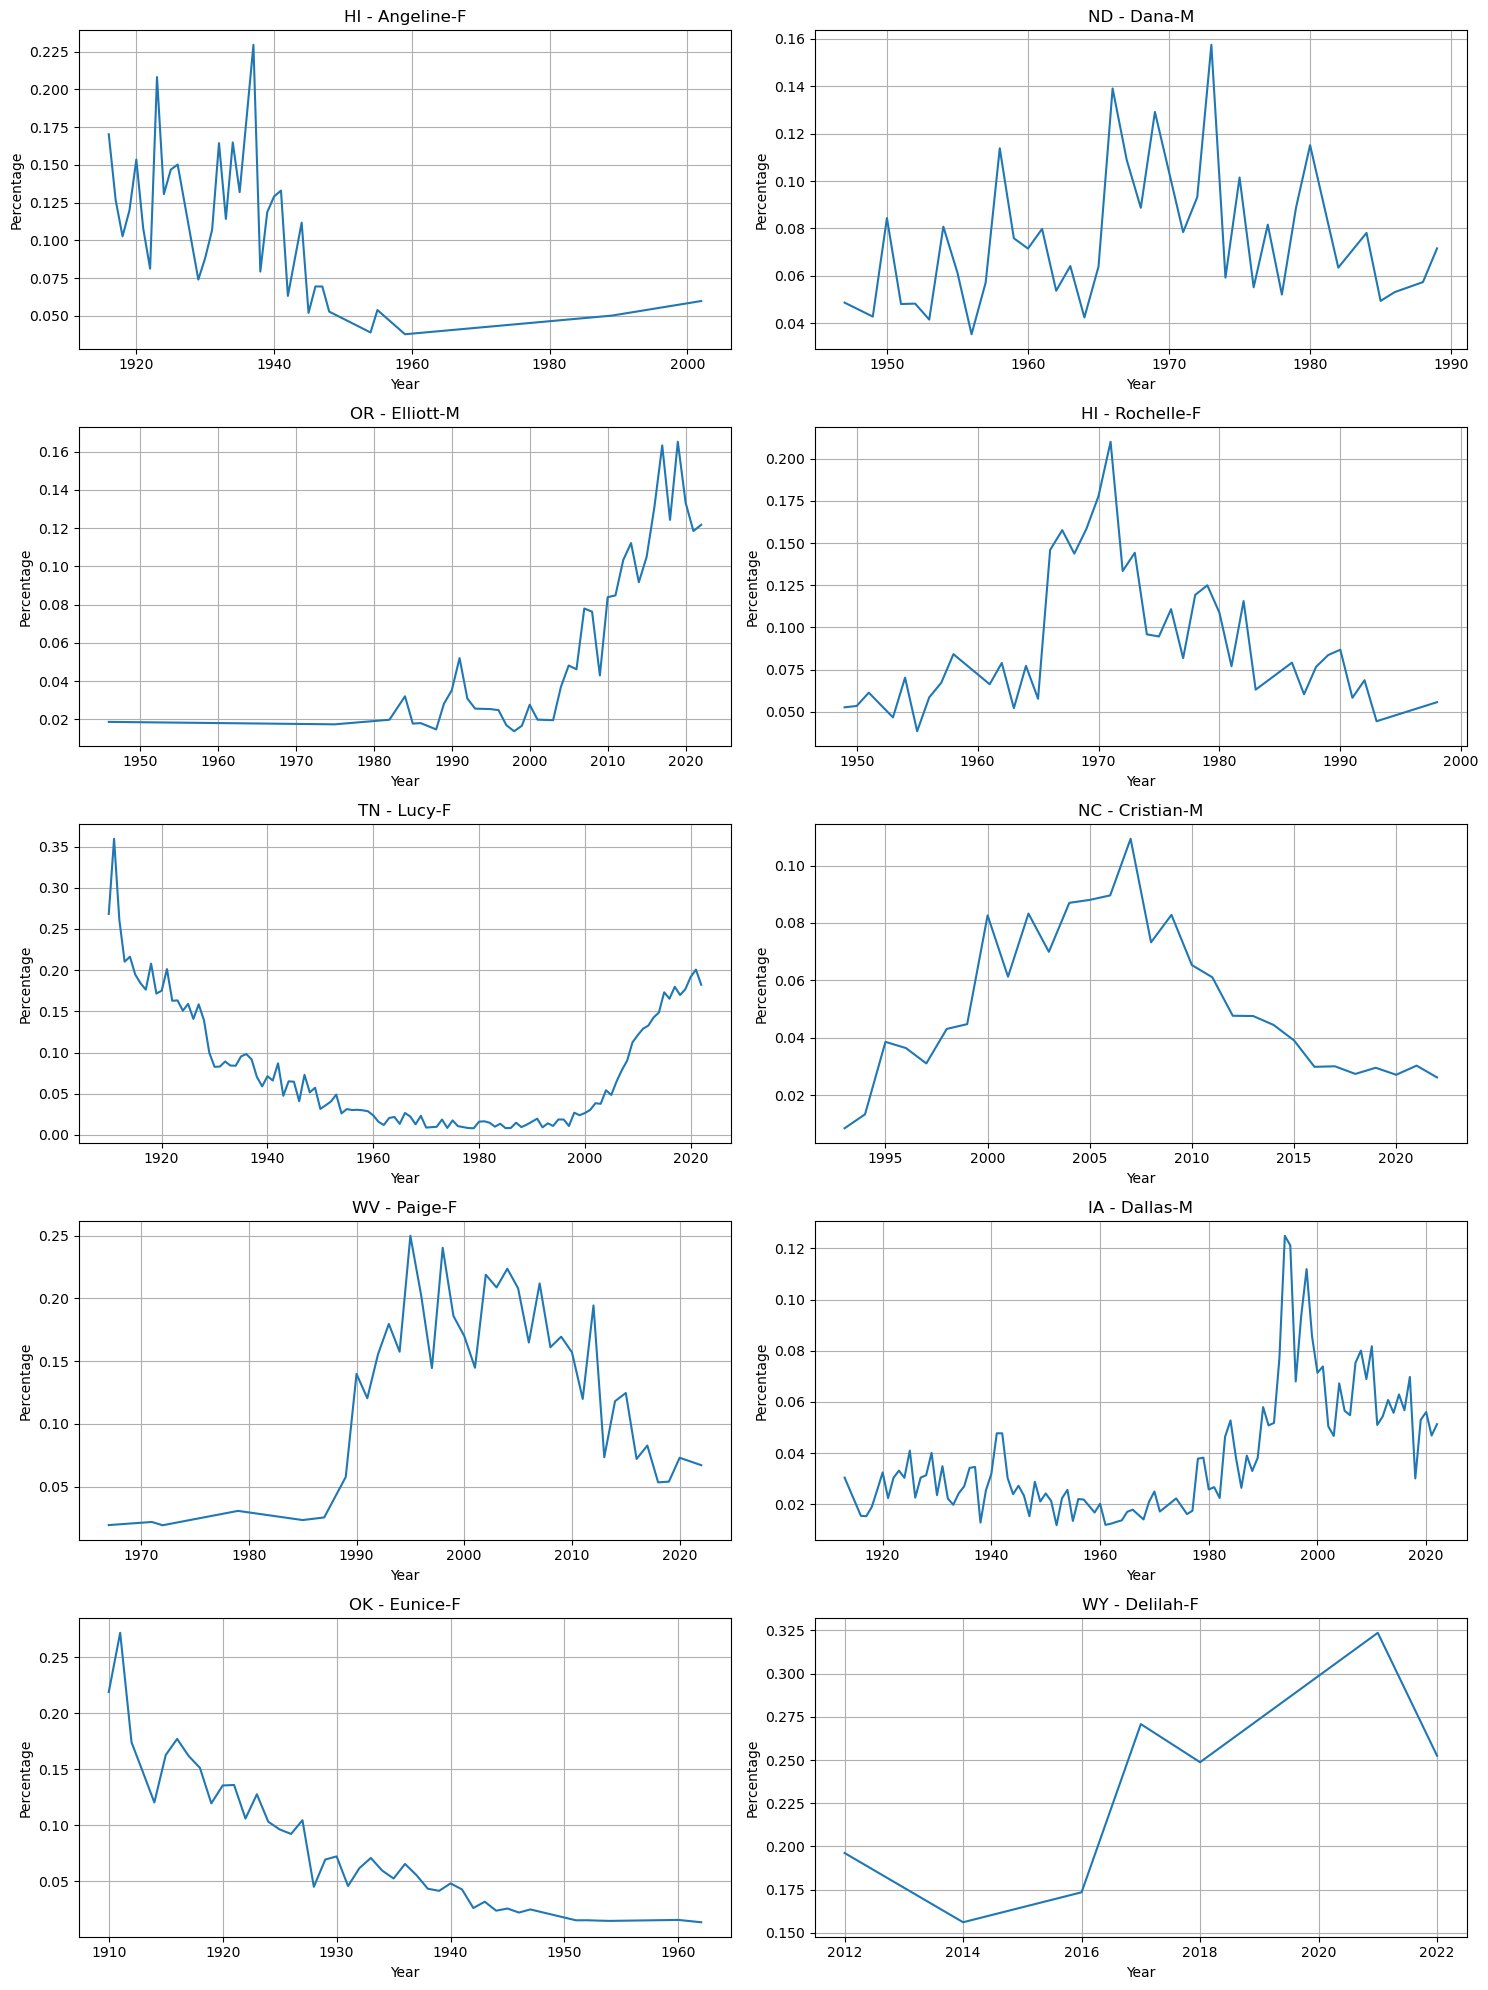

In [22]:
# now show plots for a sample of common names
np.random.seed(42)

unique_combinations = common_names.drop_duplicates(subset=['state', 'name'])
sampled_combinations = unique_combinations.sample(n=10)

fig, axs = plt.subplots(5, 2, figsize=(15, 20))  # 5x2 subplots
axs = axs.flatten()  # Flatten the array for easy iteration

for i, (index, row) in enumerate(sampled_combinations.iterrows()):
    data_subset = df2[(df2['state'] == row['state']) & (df2['name'] == row['name'])]
    
    axs[i].plot(data_subset['year'], data_subset['perc'])
    axs[i].set_title(f"{row['state']} - {row['name']}")
    axs[i].set_xlabel('Year')
    axs[i].set_ylabel('Percentage')
    axs[i].grid(True)

plt.tight_layout()
plt.show()

## conclusion 1: the time series shapes are all over the place
This might make it difficult for forecasting to work without external data. But maybe neural netowrks are an option.

In [23]:
# this is the list of time series plotted above
sampled_combinations

,name,state,first_year,last_year,max_perc,year_range
27589,Angeline-F,HI,1916,2002,0.229471,87
102482,Dana-M,ND,1947,1989,0.157518,43
135113,Elliott-M,OR,1946,2022,0.165158,77
361228,Rochelle-F,HI,1949,1998,0.209988,50
280968,Lucy-F,TN,1910,2022,0.359468,113
97682,Cristian-M,NC,1993,2022,0.109325,30
338512,Paige-F,WV,1967,2022,0.249942,56
101240,Dallas-M,IA,1913,2022,0.124908,110
145041,Eunice-F,OK,1910,1962,0.271596,53
112779,Delilah-F,WY,2012,2022,0.323625,11


## dig into one example, using Data Mining II homework assignments as template

In [24]:
name='Lucy-F'
state='TN'
title = name + ' ' + state

In [25]:
# are there any gaps that will break my seasonal decomposition?
name_state_gap.loc[(name_state_gap['name']==name) & (name_state_gap['state']==state)]

,state,name,gap_start,gap_end,gap_length
1816817,TN,Lucy-F,1971.0,1971.0,1.0
1821041,TN,Lucy-F,1977.0,1977.0,1.0
1830047,TN,Lucy-F,1990.0,1990.0,1.0


* I manually fixed the gaps, below (= 0.01 percent), since there are only three gaps and they are only 1 year in duration
* but maybe come-up with algorithm/function to fill gaps if we ultimately use these tools.
* (some of the tools below do not work if there are gaps, and some do not work if a value==0)

## seasonal decomposition

In [26]:
def sea_decomp(ser, model="additive"):
    """
    Takes in a series and a "model" parameter indicating which seasonal decomp to perform
    """
    result = None
    
    # YOUR CODE HERE
    dec = seasonal_decompose(ser, model=model)
    result = dec# .DecomposeResult()
    
    return result

In [27]:
df = df2.loc[(df2['name']==name) & (df2['state']==state)][['year','perc']]
df.loc[len(df.index)] = [1971, 0.01]
df.loc[len(df.index)] = [1977, 0.01]
df.loc[len(df.index)] = [1990, 0.01]
df.sort_values(by=['year'], inplace=True)
# set year as index and set as datetime
df['year'] = pd.to_datetime(df.year, format='%Y')
df.set_index('year', inplace=True)
# df.head()
# df.squeeze()

In [28]:
def load_data_1(df=df):
    return df.squeeze()

In [29]:
load_data_1()

year
1910-01-01    0.268307
1911-01-01    0.359468
1912-01-01    0.260862
1913-01-01    0.210309
1914-01-01    0.216371
                ...   
2018-01-01    0.169907
2019-01-01    0.176886
2020-01-01    0.191708
2021-01-01    0.200713
2022-01-01    0.182299
Name: perc, Length: 113, dtype: float64

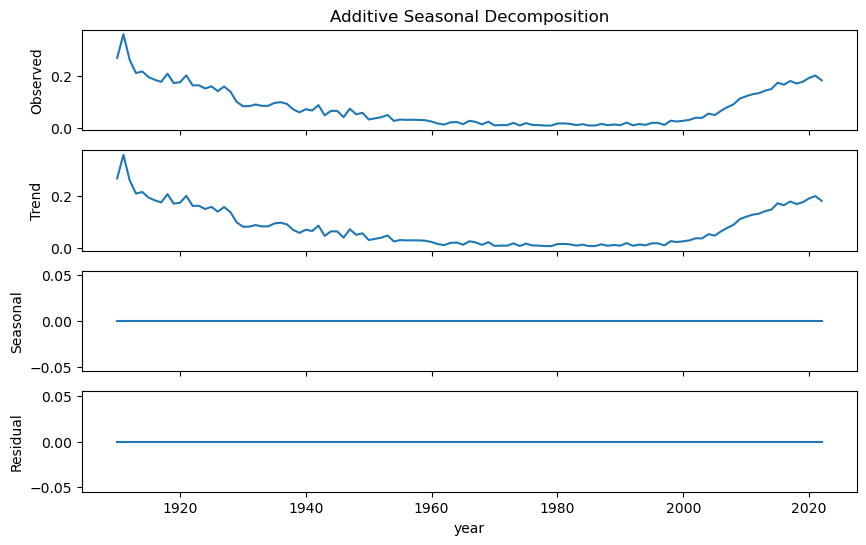

In [30]:
fig, axes = plt.subplots(4, 1, figsize=(10, 6), sharex=True)
res = sea_decomp(load_data_1(), model="additive")

axes[0].set_title("Additive Seasonal Decomposition")
axes[0].plot(res.observed)
axes[0].set_ylabel("Observed")

axes[1].plot(res.trend)
axes[1].set_ylabel("Trend")

axes[2].plot(res.seasonal)
axes[2].set_ylabel("Seasonal")

axes[3].plot(res.resid)
axes[3].set_ylabel("Residual")

axes[3].set_xlabel("year")
# fig.suptitle("Daily New COVID-19 Cases Worldwide", x=0.513, y=0.95)

del fig, axes, res

Not sure why the above does not work at all. I would think that it might at least recognize the overall "smile" shape as 1/2 of a cycle. Perhaps parameters? Code error?

"Multiplicative" looks the same as "additive"

## fit a trend curve

In [31]:
def fit_trend(ser, n):
    """
    Takes a series and fits an n-th order polynomial to the series. 
    Returns the predictions. 
    """
    
    trend_curve = None
    train_X, train_y = None, None # xi's and yi's

    # Create train_X and train_y
    # YOUR CODE HERE
    # raise NotImplementedError()
    df = pd.DataFrame({'date':ser.index, 'cases':ser.values})
    mindate = df['date'].min()
    df['daynum'] = (df['date'] - mindate).dt.days
    train_X = df['daynum'].values
    train_y = df['cases'].values
    
    # Fit a polynomial regression model - code given to you
    train_X = PolynomialFeatures(n).fit_transform(train_X.reshape(-1, 1))
    lin_reg = LinearRegression().fit(train_X, train_y.reshape(-1))
    
    # Make predictions to create the trend curve
    # YOUR CODE HERE
    # raise NotImplementedError()
    trend_curve = lin_reg.predict(train_X)
    
    return trend_curve # df.head() # 


To get different shapes, Play with the # in this line: preds = fit_trend(ser, 6)

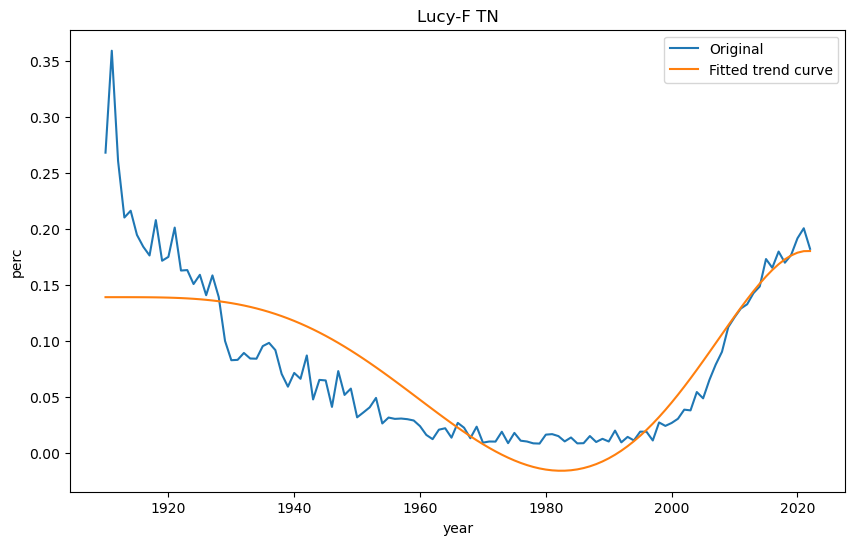

In [32]:
fig, ax = plt.subplots(figsize=(10, 6))
ser = load_data_1()
preds = fit_trend(ser, 6)
ax.plot(ser.index, ser.values, label="Original")
ax.plot(ser.index, preds, label="Fitted trend curve")
ax.set_xlabel("year")
ax.set_ylabel("perc")
ax.set_title(title)
ax.legend()

del fig, ax, ser, preds



##  (skipping weighted moving average and exponential moving average, for now)

## (come back to assignment 2 part 2 to compare states (and maybe to compare names, and maybe compare M/F))

## single time series forecasting

In [33]:
def calc_rolling_stats(ser, wd_size=7):
    """
    Takes in a series and returns the rolling mean and the rolling std for a window of size wd_size
    """
    
    rolling_mean, rolling_std = None, None
    
    # YOUR CODE HERE
    rolling_mean = np.zeros(len(ser))
    rolling_std = np.zeros(len(ser))
    for i in range(len(ser)):
        rolling_mean[i] = np.mean(ser[max(0,i-wd_size+1):i+1])
        rolling_std[i] = np.std(ser[max(0,i-wd_size+1):i+1])
    return rolling_mean, rolling_std

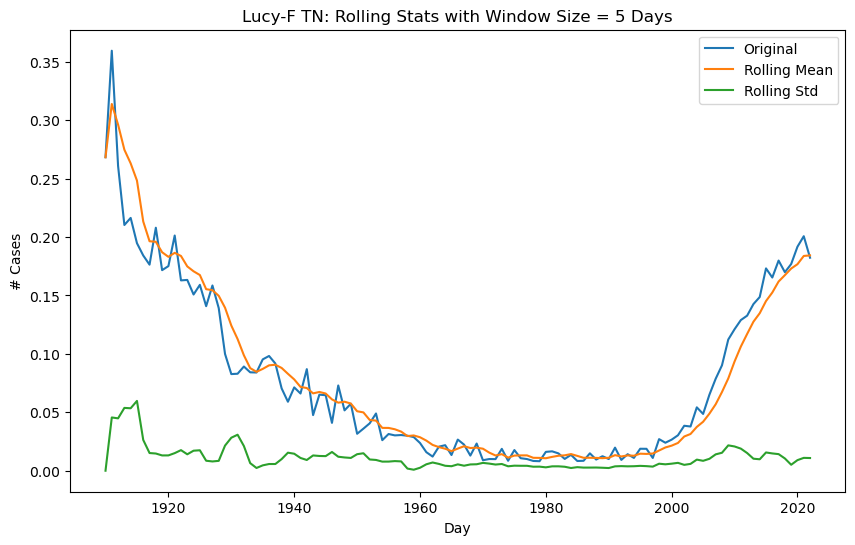

In [34]:
ser, wd_size = load_data_1(), 5
rolling_mean, rolling_std = calc_rolling_stats(ser, wd_size)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(ser, label="Original")
ax.plot(pd.Series(rolling_mean, index=ser.index), label="Rolling Mean")
ax.plot(pd.Series(rolling_std, index=ser.index), label="Rolling Std")

ax.set_xlabel("Day")
ax.set_ylabel("# Cases")
ax.set_title(title + f": Rolling Stats with Window Size = {wd_size} Days")
ax.legend()

del fig, ax, ser, wd_size, rolling_mean, rolling_std

## autocorrelations

In [35]:
def calc_acf(ser, max_lag):
    """
    Takes a series and calculates the ACF
    """
    
    ans_acf = None
    
    # YOUR CODE HERE
    from statsmodels.tsa.stattools import acf
    ans_acf = acf(ser, nlags=max_lag)
    
    
    return ans_acf

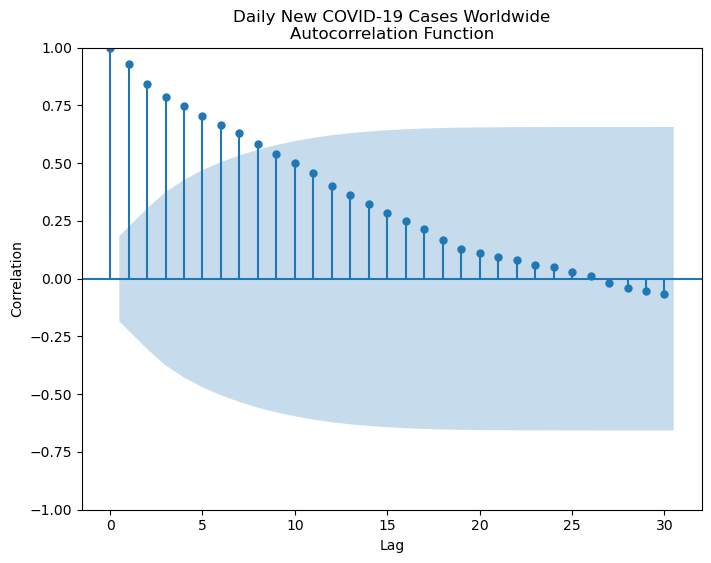

In [36]:
from statsmodels.graphics.tsaplots import plot_acf

ser, max_lag = load_data_1(), 30

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

plot_acf(ser, ax, lags=max_lag, title="Daily New COVID-19 Cases Worldwide\nAutocorrelation Function")
ax.set_xlabel(r"Lag")
ax.set_ylabel(r"Correlation")

del fig, ax, ser, max_lag, plot_acf

So it looks like the previous values are significantly correlated going back about 7 or 8 years.

## partial autocorrelation

In [37]:
def calc_pacf(ser, max_lag):
    """
    Takes a series and calculates the PACF
    """
    
    ans_pacf = None
    
    # YOUR CODE HERE
    from statsmodels.tsa.stattools import pacf
    ans_pacf = pacf(ser, nlags=max_lag)
    
    return ans_pacf

/Users/paulschickler/anaconda3/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


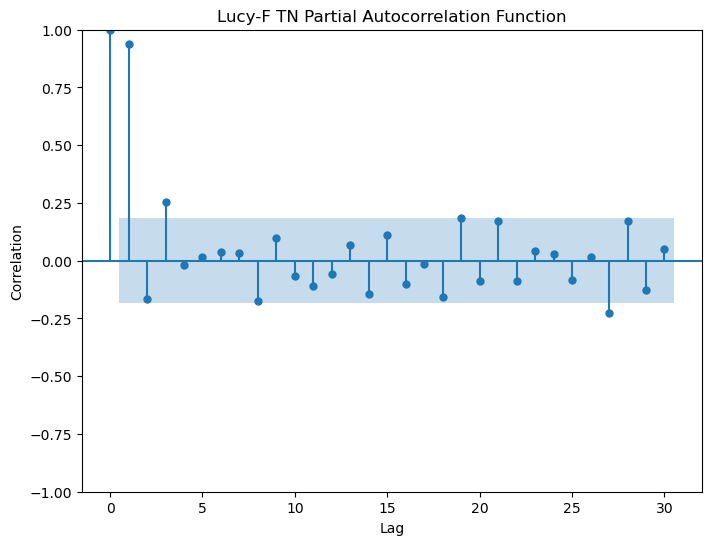

In [38]:
from statsmodels.graphics.tsaplots import plot_pacf

ser, max_lag = load_data_1(), 30

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

plot_pacf(ser, ax, lags=max_lag, title=title + " Partial Autocorrelation Function")
ax.set_xlabel(r"Lag")
ax.set_ylabel(r"Correlation")

del fig, ax, ser, max_lag, plot_pacf

The above implies that the previous year is, by far, the most the most important lag to look at (if it is available)

## ARIMA

In [39]:
from statsmodels.tsa.arima.model import ARIMA

def arima_diff(ser, p, q, num_forecasts, d=0):
    """
    Takes a series and fits an ARIMA(p, q... d) model
    Returns a number of forecasts as specified by num_forecasts. 
    """
    
    forecasts = None
    
    # YOUR CODE HERE
    # raise NotImplementedError()
    import datetime
    
    mod = ARIMA(ser, order=(p,d,q))
    res = mod.fit()

    returns = res.forecast(num_forecasts)
    
    return returns # res.summary() # forecasts

/Users/paulschickler/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/paulschickler/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/paulschickler/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/paulschickler/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/lb/1f9q5kds7h5c90s9vmqdd9qm0000gn/T/ipykernel_18967/2364141724.p

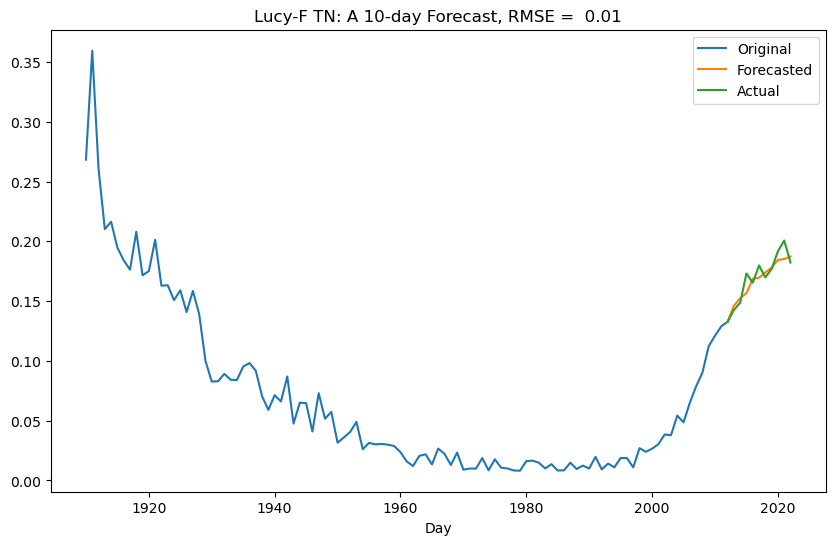

In [40]:
num_years_to_predict = 10
ser = load_data_1()
length = len(ser)
actual = ser.tail(num_years_to_predict) # 2013-2022
ser = ser.head(length-num_years_to_predict) # -2012

d = 0
p, q, num_forecasts = 8, 2, num_years_to_predict

forecasts = arima_diff(ser, p, q, num_forecasts, d)
# actual = pd.read_pickle("assets/actual.pkl")
rmse = np.sqrt(np.mean((actual - forecasts) ** 2))

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(ser, label="Original")
ax.plot(ser[-1:].append(forecasts), label="Forecasted")
ax.plot(ser[-1:].append(actual), label="Actual")

ax.set_xlabel("Day")
ax.set_title(title + f": A {len(forecasts)}-day Forecast, RMSE = {rmse: .2f}")
ax.legend()

del fig, ax, ser, p, q, num_forecasts, forecasts, actual

the above looks pretty good with:
* num_years_to_predict = 10
* d = 0
* p, q = 8, 2

**But it falls apart with, for example, num_years_to_predict=20**

## Vector Autoregression (VAR) and independent AR models

VAR may not be the right solution. It works off the idea that the names influence each other. 

try 10 years of prediction. Also 20 years. So names must have at least range ~1990-2022, with no gaps.

Which names to try?
* try with a subset of 10 name_states, to see how long it takes to run
* try for the smallest state (the one with the fewest names that meet criteria). See how long it takes. THen plot a smaller sample of results.
* try for all name_states?




In [41]:
def load_data_2(fr_yr=1990, to_yr=2022, sample_size=5, state='ZZ'):
    '''
    returns a dataframe to be used for VAR
    
    filter by year
    return data from just one state if not 'ZZ'
    remove any name_state combos that have gaps in the years
    return just a sample if sample_size not 0
    '''
    # filter by year
    df = df2[(df2['year'] >= fr_yr) & (df2['year'] <= to_yr)]
    
    # filter by state
    if state != 'ZZ':
        df = df[df['state'] == state]
    
    # pivot
    df = df.pivot_table(index='year', columns=['name', 'state'], values='perc')
    
    # set index to DateTime
    df.index = pd.DatetimeIndex(df.index.astype(str), name='year')
    
    # if gaps in any column (name_state), drop the column
    df = df.dropna(axis=1, how='any')
    
    # just return a sample of columns
    if sample_size != 0:
        sample_size = min(sample_size, len(df.columns))
        df = df.sample(n=sample_size, axis=1, random_state=42)
    
    # flatten column index
    # df.columns = ['_'.join(col).strip() for col in df.columns.values]
    df.columns = df.columns.to_flat_index().str.join('_')
    
    return df

In [42]:
load_data_2().head()

,Robel-M_US,Helen-F_AL,Bessie-F_US,Damonte-M_US,David-M_DC
year,,,,,
1990-01-01,0.000177,0.024198,0.001847,0.000582,1.170136
1991-01-01,0.000205,0.018575,0.001669,0.001232,1.039320
1992-01-01,0.000312,0.016759,0.001328,0.001276,1.035213
1993-01-01,0.000345,0.025396,0.000637,0.001459,0.982698
1994-01-01,0.000457,0.023830,0.000995,0.001318,0.960395


In [43]:
from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.var_model import VARResults, VARResultsWrapper

def var_first_diff(df, p, num_forecasts):
    """
    Fits a VAR(p) model on the first-order diff on a df and makes num_forecasts forecasts
    """
    var_res, forecasts = None, None
    
    # YOUR CODE HERE
    # ref: https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/
    
    import datetime
    
    # get differences
    df_differenced = df.diff().dropna()
    
    model = VAR(df_differenced)
    var_res = model.fit(p)
    
    forecast_input = df_differenced.values[:]
    
    fc_diff = var_res.forecast(y=forecast_input, steps=num_forecasts)
    # build index for x days into the future
    idx = df.index[-num_forecasts:] + datetime.timedelta(days=num_forecasts)
    fc1 = pd.DataFrame(fc_diff, index=idx, columns=df.columns)
    
    # de-difference
    df_fc = fc1.copy()
    columns = df.columns
    for col in columns:
        df_fc[col] = df[col].iloc[-1] + df_fc[col].cumsum()
    
    forecasts = df_fc
    
    return var_res, forecasts

In [44]:
num_forecasts = 10
p = 8 # the number of lags
fr = 1960
to = 2022
samples_to_run = 10
state = 'ZZ' # 'ZZ means all'
df = load_data_2(fr, to, samples_to_run, state)  # fr_year, to_year, sample_size, state
# first_predict = pd.to_datetime(to - num_forecasts + 1)

In [46]:
# actual

/Users/paulschickler/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/var/folders/lb/1f9q5kds7h5c90s9vmqdd9qm0000gn/T/ipykernel_18967/2458534151.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df.iloc[-1:].append(actual).plot(ax=axes[1], legend=False)
/var/folders/lb/1f9q5kds7h5c90s9vmqdd9qm0000gn/T/ipykernel_18967/2458534151.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df.iloc[-1:].append(forecasts).plot(ax=axes[1], legend=False, style=["-."] * df.shape[-1], linewidth=4)


<Axes: xlabel='year'>

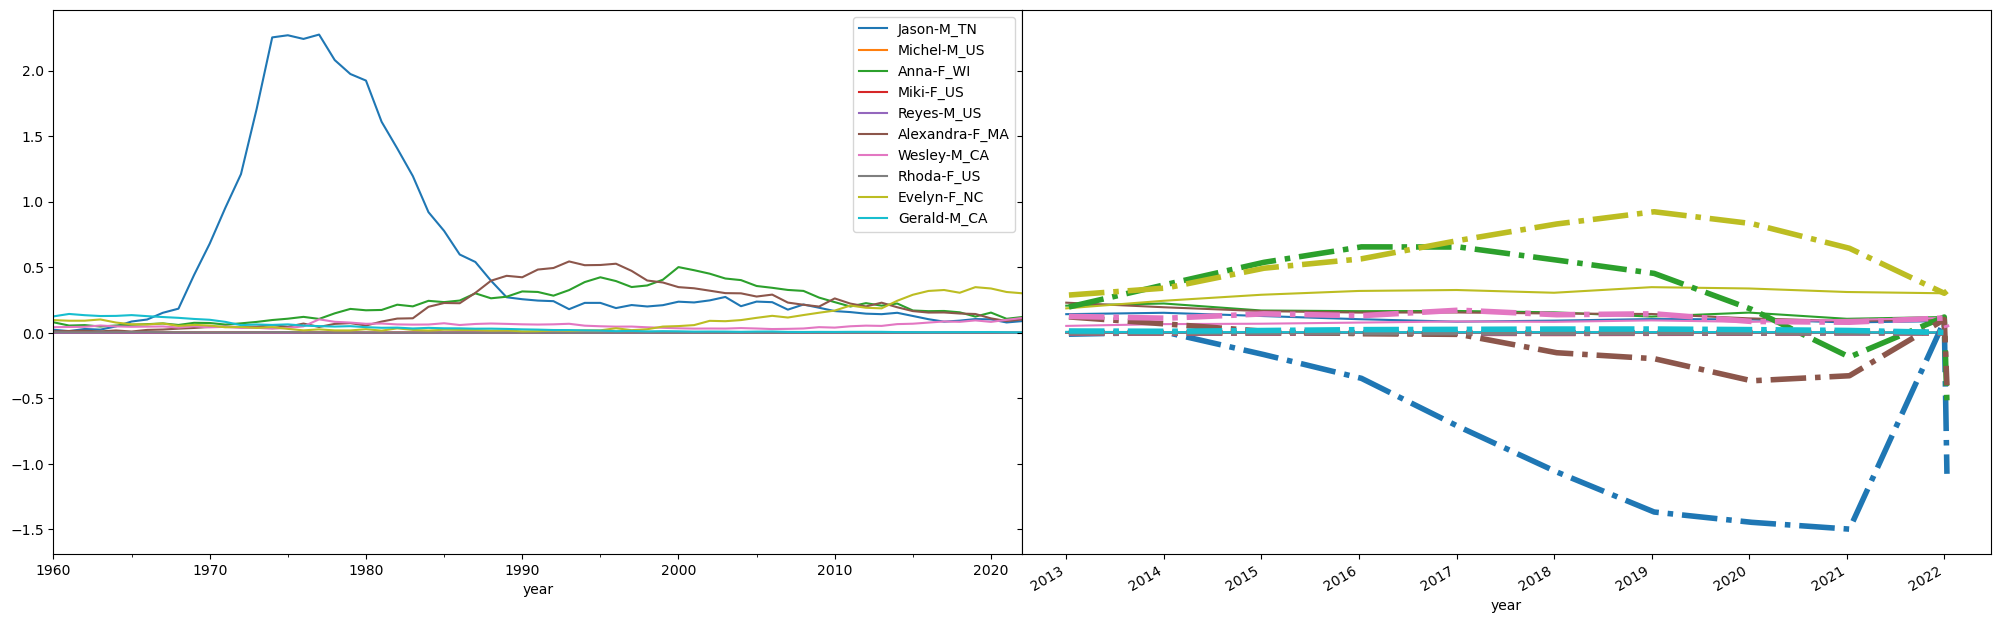

In [47]:
_, forecasts = var_first_diff(df, p, num_forecasts)
# actual = pd.read_pickle("assets/actual_multi.pkl")
actual = df.tail(num_forecasts)

rmse = np.sqrt(np.mean((actual - forecasts) ** 2, axis=0)).round(2)

fig, axes = plt.subplots(1, 2, figsize=(25, 8), sharey=True, gridspec_kw={"wspace": 0})

df.plot(ax=axes[0])

df.iloc[-1:].append(actual).plot(ax=axes[1], legend=False)
axes[1].set_prop_cycle(None)

df.iloc[-1:].append(forecasts).plot(ax=axes[1], legend=False, style=["-."] * df.shape[-1], linewidth=4)

# axes[0].set_title(f"Names until {forecasts.index[0]}", fontsize=14)
# axes[1].set_title(r"Forecasted $-\cdot-\cdot-$ and Actual --- " + "\n" + f"RMSE: {rmse.to_dict()}", fontsize=14)

Obviously the above did not work. The graphs scales are not right and there are lots of negative name counts forecasted!

In [48]:
# "Names until {}"
forecasts.index[0]

Timestamp('2013-01-11 00:00:00')

In [49]:
rmse.to_dict()

{'Jason-M_TN': nan,
 'Michel-M_US': nan,
 'Anna-F_WI': nan,
 'Miki-F_US': nan,
 'Reyes-M_US': nan,
 'Alexandra-F_MA': nan,
 'Wesley-M_CA': nan,
 'Rhoda-F_US': nan,
 'Evelyn-F_NC': nan,
 'Gerald-M_CA': nan}

# (ignore rest of notebook)

## find names that are popular in some states, but not in others

In [ ]:
# create a df aggregated for the nation
dfn1 = dfs1.groupby(['sex','year', 'name']).sum(numeric_only=True).reset_index()
year_count = dfn1[['year', 'count']].groupby('year').sum(numeric_only=True).reset_index()
dfn2 = pd.merge(dfn1, year_count, on="year", suffixes=('', '_all'))
dfn2['perc'] = 100*dfn2['count']/dfn2['count_all']
dfn2['state'] = 'all'
dfn2.head()

In [ ]:
# get percentages by state and year
year_count = dfs1[['state', 'year', 'count']].groupby(['state','year']).sum(numeric_only=True).reset_index()
dfs2 = pd.merge(dfs1, year_count, on=["state", "year"], suffixes=('', '_all'))
dfs2['perc'] = 100*dfs2['count']/dfs2['count_all']
print(dfs2.head())
# test
dfs2[['state', 'year', 'perc']].groupby(['state', 'year']).sum().sample(5)

In [ ]:
# for each year and name (and sex), calculate average across all 51 states
# for each year and name (and sex), calculate std dev across all 51 states
# for each year and name (and sex), calculate z-score across all 51 states
grouped_stats = dfs2.groupby(['name', 'sex', 'year'])['perc'].agg(['mean', 'std']).reset_index()
dfs3 = pd.merge(dfs2, grouped_stats, on=['name', 'sex', 'year'], how='left')
dfs3['z_score'] = (dfs3['perc'] - dfs3['mean']) / dfs3['std']
dfs3.sort_values(by='z_score', inplace=True)

In [ ]:
# lowest z-scores: 
# these are states and years where a name is used infrequently compared to other states
dfs3.head(10)

In [ ]:
# null z-scores
# these aere states and years where a name appears ONLY in that state
dfs3[dfs3['z_score'].isnull()].sort_values(by="name").sample(10)

In [ ]:
# high z-scores and only since 1990
# these are names that are used a lot in a particular state (veresus other states in that year)
zzz = dfs3[~dfs3['z_score'].isnull()]
zzz.loc[zzz['year']>1990].tail(10)

In [ ]:
# sample of low z-scores: 
# these are states and years where a name is used infrequently compared to other states
dfs3.loc[dfs3['z_score']<-3].sample(10)

In [ ]:
# sample of high z-scores: 
# these are states and years where a name is used frequently compared to other states
dfs3.loc[dfs3['z_score']>6].sample(10)

## some interesting names

In [ ]:
df2.loc[df2['name']=='Kimimila']

In [ ]:
dfs2.loc[dfs2['name']=='Female']

In [ ]:
dfs2.loc[dfs2['name']=='Kizzie']

In [ ]:
name, sex = "Linda", "F"   # 'Kizzie', 'F' 
y1, y2 = 1941, 1955        # 1970, 2022


zzz = dfs3[(dfs3['name'] == name) & (dfs3['sex'] == sex) & (dfs3['year'] >= y1) & (dfs3['year'] <= y2)] # 
# LA and GA lag the others for Kizzie

pivot_df = zzz.pivot(index='year', columns='state', values='perc')
plt.figure(figsize=(10, 6))
for column in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[column], label=column)
    # add label to line
    # if np.isfinite(pivot_df[column].iloc[-1]):
    #     plt.text(pivot_df.index[-1], pivot_df[column].iloc[-1], f'{column}', va='center')


plt.title('Percentage by Year for Name ' + name)
plt.xlabel('Year')
plt.ylabel('Percentage')
plt.legend(title='State')
plt.show()


In [ ]:
zzz.head()